<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [44]:
# ## install finrl library
!pip install wrds
!pip install swig
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install pandas_market_calendars


zsh:1: command not found: apt-get
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-req-build-6vv79ksj
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-req-build-6vv79ksj
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d25d902a6de54931a329adc38a2663e8f576adc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-install-s3vcv0n_/elegantrl_71bb3eeffbd049aa8c9fb19cce28cdea
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/ks/bjl76g8d4zxgw0m5p8z2pd9r0000gn/T/pip-install-s3vcv0n_/elegantrl_7


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [45]:
import warnings
warnings.filterwarnings("ignore")

In [46]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
import sys
import os

# Add path to model.py
sys.path.append(os.path.abspath("."))  # or use a specific folder path

# Import your custom agent
from models import DRLEnsembleAgent

import sys
sys.path.append("../FinRL-Library")

<a id='1.4'></a>
## 2.4. Create Folders

In [47]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

print(DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR)


datasets trained_models tensorboard_log results


In [48]:
print(DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR)

datasets trained_models tensorboard_log results


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [49]:
df = pd.read_csv('data.csv')

In [50]:
df.head()

,date,close,high,low,open,volume,tic,day
0,2015-02-01,228.99,233.790,210.00,218.67,7220.0,btcusd,6
1,2015-02-02,112.20,112.230,112.00,112.06,2792120.0,agg,0
2,2015-02-02,91.46,91.480,91.46,91.48,3557487.0,bil,0
3,2015-02-02,237.83,240.100,220.89,228.39,7421.0,btcusd,0
4,2015-02-02,122.42,123.155,121.82,121.84,8885189.0,gld,0


In [51]:
df.tail()

,date,close,high,low,open,volume,tic,day
24238,2025-04-11,533.94,536.430,520.0700,523.01,97866334.0,spy,4
24239,2025-04-11,205.82,206.440,199.2843,202.69,1652602.0,vb,4
24240,2025-04-11,83.63,83.800,81.0700,82.05,5276100.0,vnq,4
24241,2025-04-11,243.62,244.330,236.5926,239.25,1396703.0,vo,4
24242,2025-04-11,43.10,43.155,42.3250,42.55,16757189.0,vwo,4


In [52]:
df.shape

(24243, 8)

In [53]:
day_values_per_tic = df.groupby('tic')['day'].apply(lambda x: sorted(x.unique())).reset_index()
day_values_per_tic.columns = ['tic', 'unique_days']

# Display
print(day_values_per_tic)

      tic            unique_days
0     agg        [0, 1, 2, 3, 4]
1     bil        [0, 1, 2, 3, 4]
2  btcusd  [0, 1, 2, 3, 4, 5, 6]
3     gld        [0, 1, 2, 3, 4]
4     spy        [0, 1, 2, 3, 4]
5      vb        [0, 1, 2, 3, 4]
6     vnq        [0, 1, 2, 3, 4]
7      vo        [0, 1, 2, 3, 4]
8     vwo        [0, 1, 2, 3, 4]


In [54]:
# Match 5-day and 7-day tickers using apply
tics_5day = day_values_per_tic[day_values_per_tic['unique_days'].apply(lambda x: x == list(range(5)))]['tic']
tics_7day = day_values_per_tic[day_values_per_tic['unique_days'].apply(lambda x: x == list(range(7)))]['tic']

# Filter the original df
df_5day_full = df[df['tic'].isin(tics_5day)]
df_7day_full = df[df['tic'].isin(tics_7day)]

# Results
print("5-day tickers:", tics_5day.tolist())
print("7-day tickers:", tics_7day.tolist())
print("5-day df shape:", df_5day_full.shape)
print("7-day df shape:", df_7day_full.shape)

5-day tickers: ['agg', 'bil', 'gld', 'spy', 'vb', 'vnq', 'vo', 'vwo']
7-day tickers: ['btcusd']
5-day df shape: (20520, 8)
7-day df shape: (3723, 8)


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [55]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df_5day_full = fe.preprocess_data(df_5day_full)
df_7day_full = fe.preprocess_data(df_7day_full)

Successfully added technical indicators
Successfully added technical indicators


In [56]:
df_5day_full.shape

(20520, 16)

In [57]:
df_7day_full.shape

(3723, 16)

In [58]:
df = pd.concat([df_5day_full, df_7day_full], ignore_index=False)
df.index = range(len(df))  # Assign new sequential index


In [59]:
df.shape

(24243, 16)

In [60]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02,112.20,112.230,112.00,112.06,2792120.0,agg,0,0.0,112.593112,111.376888,0.0,-66.666667,100.0,112.20,112.20
1,2015-02-02,91.46,91.480,91.46,91.48,3557487.0,bil,0,0.0,112.593112,111.376888,0.0,-66.666667,100.0,91.46,91.46
2,2015-02-02,122.42,123.155,121.82,121.84,8885189.0,gld,0,0.0,112.593112,111.376888,0.0,-66.666667,100.0,122.42,122.42
3,2015-02-02,201.92,202.030,197.86,200.05,163106969.0,spy,0,0.0,112.593112,111.376888,0.0,-66.666667,100.0,201.92,201.92
4,2015-02-02,115.12,115.210,112.85,114.38,549866.0,vb,0,0.0,112.593112,111.376888,0.0,-66.666667,100.0,115.12,115.12


In [61]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Remove rows where the date appears only once
df = df[df.groupby('date')['date'].transform('count') > 1]

# Sort by date
df = df.sort_values('date').reset_index(drop=True)


In [62]:
df.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02,112.20,112.2300,112.0000,112.06,2792120.0,agg,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,112.20,112.20
1,2015-02-02,40.65,40.7600,40.2800,40.40,15944366.0,vwo,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,40.65,40.65
2,2015-02-02,122.30,122.3899,119.9400,121.66,823489.0,vo,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,122.30,122.30
3,2015-02-02,86.32,86.6900,84.6851,86.53,7523640.0,vnq,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,86.32,86.32
4,2015-02-02,237.83,240.1000,220.8900,228.39,7421.0,btcusd,0,0.198333,245.911648,220.908352,100.0,66.666667,100.0,233.41,233.41


In [63]:
df.sort_values(['date','tic']).head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2015-02-02,112.20,112.230,112.00,112.06,2792120.0,agg,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,112.20,112.20
7,2015-02-02,91.46,91.480,91.46,91.48,3557487.0,bil,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,91.46,91.46
4,2015-02-02,237.83,240.100,220.89,228.39,7421.0,btcusd,0,0.198333,245.911648,220.908352,100.0,66.666667,100.0,233.41,233.41
6,2015-02-02,122.42,123.155,121.82,121.84,8885189.0,gld,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,122.42,122.42
5,2015-02-02,201.92,202.030,197.86,200.05,163106969.0,spy,0,0.000000,112.593112,111.376888,0.0,-66.666667,100.0,201.92,201.92


In [64]:
len(df.tic.unique())

9

In [65]:
df.tic.value_counts()

tic
agg       2565
vwo       2565
vo        2565
vnq       2565
btcusd    2565
spy       2565
gld       2565
bil       2565
vb        2565
Name: count, dtype: int64

In [66]:
fe = FeatureEngineer(use_technical_indicator=False,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added turbulence index


In [67]:
processed.tail(5)

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
23080,2025-04-11,533.94,536.430,520.0700,523.01,97866334.0,spy,4,-14.420666,599.206654,500.843346,43.079253,-102.073250,32.043209,556.080667,579.253000,11.138849
23081,2025-04-11,205.82,206.440,199.2843,202.69,1652602.0,vb,4,-7.718714,241.806394,194.565606,39.597931,-134.958018,39.787079,220.631667,233.751833,11.138849
23082,2025-04-11,83.63,83.800,81.0700,82.05,5276100.0,vnq,4,-2.237379,95.845121,80.539879,41.089234,-160.026066,67.439983,89.358667,90.393500,11.138849
23083,2025-04-11,243.62,244.330,236.5926,239.25,1396703.0,vo,4,-6.750516,277.019703,229.953297,41.878472,-117.572567,35.166197,255.536667,265.137167,11.138849
23084,2025-04-11,43.10,43.155,42.3250,42.55,16757189.0,vwo,4,-0.966755,48.897241,40.331759,44.893786,-99.162018,31.952286,44.865000,44.915667,11.138849


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [68]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 9, State Space: 91


In [69]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [70]:

TRAIN_START_DATE = '2016-02-02'
TRAIN_END_DATE = '2022-07-06'
TRADE_START_DATE = '2022-07-27'
TRADE_END_DATE = '2025-04-07'

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [71]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)


In [72]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
                      "batch_size": 128,
                      "buffer_size": 100000,
                      "learning_rate": 0.0003,
                      "learning_starts": 100,
                      "ent_coef": "auto_0.1",
                    }

TD3_model_kwargs = {
                      "batch_size": 100,
                      "buffer_size": 1000000,
                      "learning_rate": 0.001
                   }



timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000,
                  'sac' : 10_000,
                 'td3' : 10_000,
                 }

In [73]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                  SAC_model_kwargs,
                                                  TD3_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  68.62442980819827
======Model training from:  2016-02-02 to  2022-07-28 00:00:00
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_13


--------------------------------------
| time/                 |            |
|    fps                | 827        |
|    iterations         | 100        |
|    time_elapsed       | 0          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -12.8      |
|    explained_variance | -0.183     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -0.775     |
|    reward             | 0.49775228 |
|    std                | 1          |
|    value_loss         | 0.698      |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 837       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -12.8     |
|    explained_variance | -0.00133  |
|    learning_rate      | 0.0007  

In [74]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2022-07-28 00:00:00,2022-10-26 00:00:00,A2C,-0.164034,-0.487804,-0.395159,-0.178656,-0.178524
1,189,2022-10-26 00:00:00,2023-01-27 00:00:00,A2C,0.470019,-0.042194,0.357686,0.119203,0.112154
2,252,2023-01-27 00:00:00,2023-04-28 00:00:00,DDPG,-0.377636,0.19129,0.207628,0.172371,-0.250565
3,315,2023-04-28 00:00:00,2023-07-31 00:00:00,TD3,0.006307,0.159154,0.368558,0.085412,0.391395
4,378,2023-07-31 00:00:00,2023-10-27 00:00:00,DDPG,-0.229865,-0.059035,0.210142,0.11181,0.20312
5,441,2023-10-27 00:00:00,2024-01-30 00:00:00,DDPG,0.149314,0.127022,0.285645,0.285634,0.279361
6,504,2024-01-30 00:00:00,2024-04-30 00:00:00,SAC,0.134315,0.330278,0.357222,0.358153,-0.197922
7,567,2024-04-30 00:00:00,2024-07-31 00:00:00,SAC,0.213753,0.138395,0.238224,0.430197,0.12481
8,630,2024-07-31 00:00:00,2024-10-29 00:00:00,DDPG,0.047066,0.181162,0.560249,0.089759,0.251279


In [75]:
print("Last possible trading date:", ensemble_agent.unique_trade_date[-1])


Last possible trading date: 2025-04-07 00:00:00


In [76]:
# prompt: Using dataframe df_summary: I need the daily return from 2024-01-02 to 2025-04-11

# Import necessary libraries
import pandas as pd

# Assuming 'df_summary' is your DataFrame
# Convert date columns to datetime objects if they are not already
df_summary['Val Start'] = pd.to_datetime(df_summary['Val Start'])
df_summary['Val End'] = pd.to_datetime(df_summary['Val End'])


# Define the start and end dates for the desired range
start_date = TRADE_START_DATE
end_date = TRADE_END_DATE

# Filter the DataFrame based on the specified date range
filtered_df = df_summary[(df_summary['Val Start'] >= start_date) & (df_summary['Val End'] <= end_date)]

# Calculate daily returns (replace this with your actual return calculation)
# This is a placeholder; replace with the correct method if you have other return data
# The code below assumes there's a 'daily_returns' column in your dataframe already.
# If not, you'll have to create it from other available data in your df.
# For instance, if you have a "price" column, you can calculate it using:
# filtered_df["daily_return"] = filtered_df["price"].pct_change()


# Display the filtered DataFrame with daily returns
filtered_df


,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2022-07-28,2022-10-26,A2C,-0.164034,-0.487804,-0.395159,-0.178656,-0.178524
1,189,2022-10-26,2023-01-27,A2C,0.470019,-0.042194,0.357686,0.119203,0.112154
2,252,2023-01-27,2023-04-28,DDPG,-0.377636,0.19129,0.207628,0.172371,-0.250565
3,315,2023-04-28,2023-07-31,TD3,0.006307,0.159154,0.368558,0.085412,0.391395
4,378,2023-07-31,2023-10-27,DDPG,-0.229865,-0.059035,0.210142,0.11181,0.20312
5,441,2023-10-27,2024-01-30,DDPG,0.149314,0.127022,0.285645,0.285634,0.279361
6,504,2024-01-30,2024-04-30,SAC,0.134315,0.330278,0.357222,0.358153,-0.197922
7,567,2024-04-30,2024-07-31,SAC,0.213753,0.138395,0.238224,0.430197,0.12481
8,630,2024-07-31,2024-10-29,DDPG,0.047066,0.181162,0.560249,0.089759,0.251279


In [77]:
for i, d in enumerate(processed.date.unique()):
    print(f"{i}: {d}")


0: 2015-02-02 00:00:00
1: 2015-02-03 00:00:00
2: 2015-02-04 00:00:00
3: 2015-02-05 00:00:00
4: 2015-02-06 00:00:00
5: 2015-02-09 00:00:00
6: 2015-02-10 00:00:00
7: 2015-02-11 00:00:00
8: 2015-02-12 00:00:00
9: 2015-02-13 00:00:00
10: 2015-02-17 00:00:00
11: 2015-02-18 00:00:00
12: 2015-02-19 00:00:00
13: 2015-02-20 00:00:00
14: 2015-02-23 00:00:00
15: 2015-02-24 00:00:00
16: 2015-02-25 00:00:00
17: 2015-02-26 00:00:00
18: 2015-02-27 00:00:00
19: 2015-03-02 00:00:00
20: 2015-03-03 00:00:00
21: 2015-03-04 00:00:00
22: 2015-03-05 00:00:00
23: 2015-03-06 00:00:00
24: 2015-03-09 00:00:00
25: 2015-03-10 00:00:00
26: 2015-03-11 00:00:00
27: 2015-03-12 00:00:00
28: 2015-03-13 00:00:00
29: 2015-03-16 00:00:00
30: 2015-03-17 00:00:00
31: 2015-03-18 00:00:00
32: 2015-03-19 00:00:00
33: 2015-03-20 00:00:00
34: 2015-03-23 00:00:00
35: 2015-03-24 00:00:00
36: 2015-03-25 00:00:00
37: 2015-03-26 00:00:00
38: 2015-03-27 00:00:00
39: 2015-03-30 00:00:00
40: 2015-03-31 00:00:00
41: 2015-04-01 00:00:00
42

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [78]:
unique_trade_date = processed[(processed.date > TRADE_START_DATE)&(processed.date <= TRADE_END_DATE)].date.unique()

In [79]:
# Step 1: Prepare the trade date DataFrame
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

# Step 2: Load and combine all account_value CSVs
df_account_value_list = []
for i in range(rebalance_window + validation_window, len(unique_trade_date) - rebalance_window, rebalance_window):
    file_path = f'results/account_value_trade_ensemble_{i}.csv'
    if os.path.exists(file_path):
        temp = pd.read_csv(file_path)
        df_account_value_list.append(temp)
    else:
        print(f"[Warning] File does not exist: {file_path}")

df_account_value = pd.concat(df_account_value_list, ignore_index=True)

# Step 3: Compute the Sharpe Ratio
returns = df_account_value.account_value.pct_change(1)
sharpe = (252 ** 0.5) * returns.mean() / returns.std()
print('Sharpe Ratio: ', sharpe)

# Step 4: Join with trade dates
df_account_value = df_account_value.join(
    df_trade_date[validation_window:].reset_index(drop=True)
)


Sharpe Ratio:  1.4222376668106012


In [80]:
# Show rows with NaN account_value before daily return calculation
nan_rows = df_account_value[df_account_value['account_value'].isna()]

if nan_rows.empty:
    print("No NaN account_value found.")
else:
    print("NaN account_value rows:")
    print(nan_rows[['datadate', 'account_value']])


No NaN account_value found.


In [81]:
# Step 5: Compute daily return with date
df_account_value['daily_return'] = df_account_value['account_value'].pct_change().fillna(0)

# Step 6: Format final output with date and daily_return
df_daily_return = df_account_value[['datadate', 'daily_return']].rename(columns={'datadate': 'date'})

# Optional: Round for clarity
df_daily_return['daily_return'] = df_daily_return['daily_return'].round(6)

# Step 7: Print or save
print(df_daily_return.head())


        date  daily_return
0 2022-10-26      0.000000
1 2022-10-27     -0.019465
2 2022-10-28      0.011364
3 2022-10-31     -0.005441
4 2022-11-01     -0.000421


In [82]:
df_account_value.head()
df_account_value.to_csv('df_account_value_ensemble.csv')

In [83]:
# Step 1: Create a copy with only the required columns
df_daily_return = df_account_value[['date', 'daily_return']].copy()

# Step 2: Replace the first daily return NaN with 0.0
df_daily_return.loc[0, 'daily_return'] = 0.0

# Step 3: Reset the index for a clean look
df_daily_return.reset_index(drop=True, inplace=True)

df_daily_return.head()



,date,daily_return
0,2022-10-26,0.000000
1,2022-10-27,-0.019465
2,2022-10-28,0.011364
3,2022-10-31,-0.005441
4,2022-11-01,-0.000421


In [84]:
df_daily_return.to_csv('df_daily_return_ensemble.csv')

In [85]:
%matplotlib inline
df_account_value.account_value.plot()

<Axes: >

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class



Performance Stats for Ensemble:

Annual return          0.637087
Cumulative returns     1.680055
Annual volatility      0.403997
Sharpe ratio           1.420817
Calmar ratio           2.720164
Stability              0.846261
Max drawdown          -0.234209
Omega ratio            1.302818
Sortino ratio          2.348491
Skew                   0.575557
Kurtosis               2.809761
Tail ratio             1.433902
Daily value at risk   -0.048621
dtype: float64


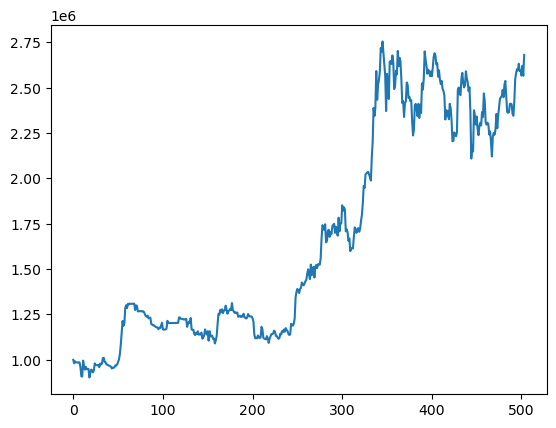

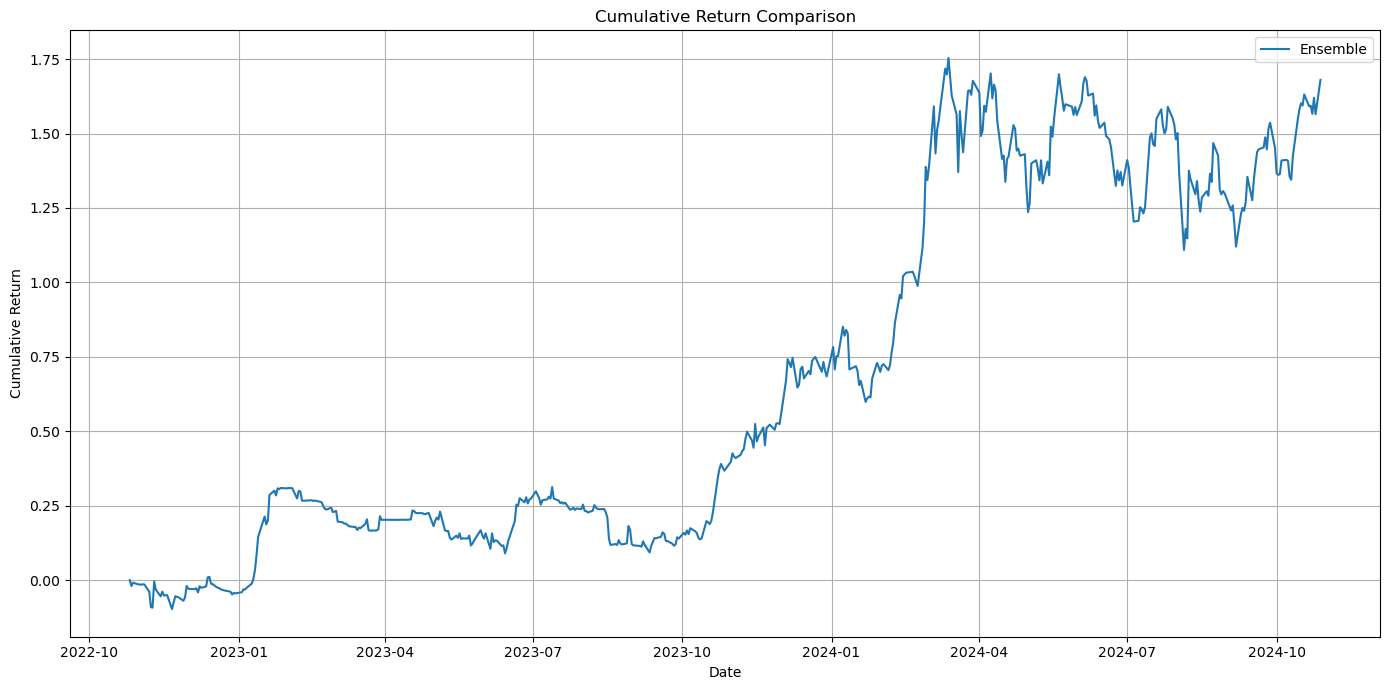

In [86]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from finrl.plot import convert_daily_return_to_pyfolio_ts

from pyfolio import timeseries

return_dfs = [df_daily_return]
agent_names = ['Ensemble']

for i, df_return in enumerate(return_dfs):
    strat = convert_daily_return_to_pyfolio_ts(df_return)
    stats = timeseries.perf_stats(strat)
    print(f"\nPerformance Stats for {agent_names[i]}:\n")
    print(stats)


# Plot cumulative return
plt.figure(figsize=(14, 7))
for df, name in zip(return_dfs, agent_names):
    # Convert to pyfolio ts and calculate cumulative return
    strat = convert_daily_return_to_pyfolio_ts(df)
    cum_return = (1 + strat).cumprod() - 1
    plt.plot(cum_return.index, cum_return.values, label=name)

plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()